In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !pip install accelerate
# !pip install diffusers
# !pip install datasets


In [5]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import timeit

In [6]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 512
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 4000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
device

'cuda'

Resolving data files:   0%|          | 0/215 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

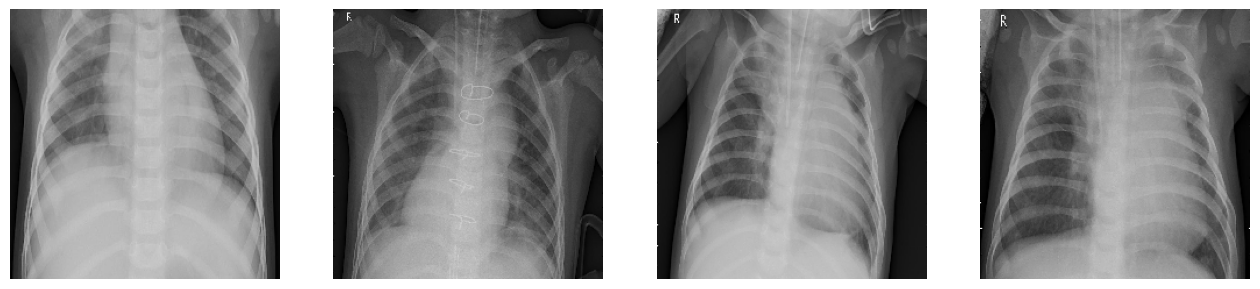

In [10]:
path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch"
dataset = load_dataset(f"{path}/chest_X_ray_pneumonia", split="train", trust_remote_code=True)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [11]:

preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)


train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


In [12]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [13]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


In [14]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

In [15]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1851, device='cuda:0', grad_fn=<MseLossBackward0>)


In [24]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

In [16]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    # if epoch%10 == 0:
    #     sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/512 [00:03<?, ?it/s]


KeyboardInterrupt: 

  0%|          | 0/4000 [00:00<?, ?it/s]

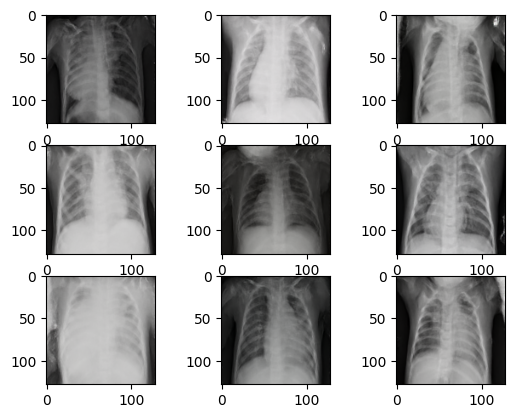

In [26]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)

In [ ]:
# # Define your save path
# save_path = r"/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch/save_model/checkpoint.pth"

# # Collect the states
# checkpoint = {
#     "model_state_dict": accelerator.unwrap_model(model).state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     "scheduler_state_dict": lr_scheduler.state_dict(),
#     "accelerator_state_dict": accelerator.state_dict()
# }

# # Save checkpoint
# torch.save(checkpoint, save_path)

In [27]:
checkpoint = {
    "model_state_dict": model.state_dict(),  # Assuming model is the actual model or accelerator.unwrap_model(model)
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": lr_scheduler.state_dict(),
}

# Define your save path
save_path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch//save_model/checkpoint_pneumonia.pth"

# Save checkpoint
torch.save(checkpoint, save_path)


In [17]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

In [18]:
# Load the checkpoint
save_path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch//save_model/checkpoint_pneumonia.pth"

checkpoint = torch.load(save_path)

# Load states into the model, optimizer, and scheduler
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
lr_scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

# If you're resuming training and need to prepare these components with Accelerator again
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)


  0%|          | 0/4000 [00:00<?, ?it/s]

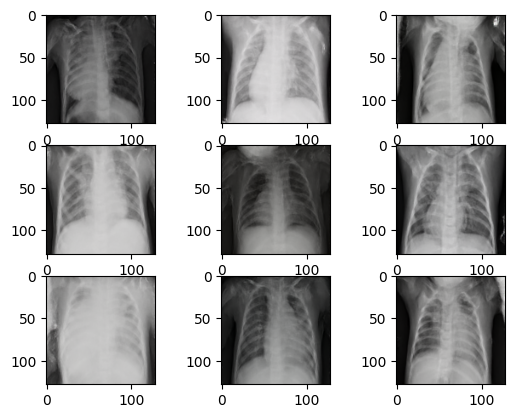

In [30]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)

In [21]:
def sample_image_generation2(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    for i, image in enumerate(images):
        if not os.path.exists(save_dir):
            # If the directory does not exist, create it
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, f"generated_image_{i+1+50}.png")
        if not isinstance(image, Image.Image):
            # Convert tensor image to PIL Image only if necessary
            pil_image = transforms.ToPILImage()(image)
        else:
            # If it's already a PIL image, no need to convert
            pil_image = image
        pil_image.save(save_path)

In [22]:
NUM_GENERATE_IMAGES = 100
RANDOM_SEED = 42
save_dir = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch/save_model/save_images_pneumonia"
sample_image_generation2(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS, save_dir)

  0%|          | 0/4000 [00:00<?, ?it/s]